In [15]:
# import librareies
import torch
from torch import nn
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np

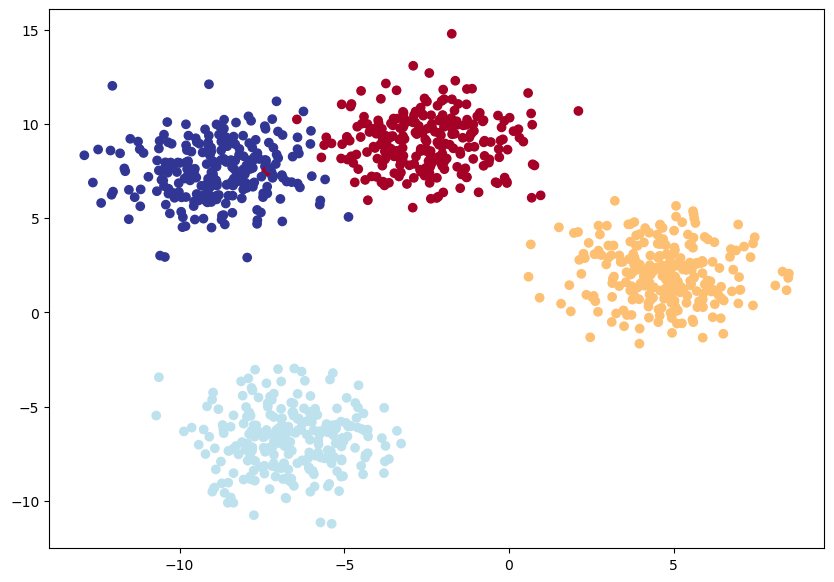

In [2]:
# create a multi-class dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create a multi-class data
X_blob, Y_blob = make_blobs(n_samples = 1000,
                            n_features= NUM_FEATURES,
                            centers= NUM_CLASSES,
                            cluster_std= 1.5,
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
Y_blob = torch.from_numpy(Y_blob).type(torch.int64)       # bcz they are integer

# split the data into train and test
X_blob_train, X_blob_test, Y_blob_train, Y_blob_test = train_test_split(X_blob,
                                                                        Y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

## plot the data
plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=Y_blob, cmap=plt.cm.RdYlBu)
plt.show()

**Set up device agnostic code**

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# build the multi-class classification model
class BlobModel(nn.Module):
    """Initializes muti-class Blob classification model

    Args:
        input_features (int): Number of input features to the model
        output_features (int): Number of output features (no of output classes)
        hidden_units(int): Number of hidden units between the layers, default = 8
        """
    def __init__(self, input_features, output_features, hidden_units = 8): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    ## over-ride the forward method
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.layers(x)
        
# create an instance of the model and put it into target device
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)

# to confirm the device of the model
next(model.parameters()).device

device(type='cuda', index=0)

In [5]:
# check the model layers architecture
model

BlobModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [6]:
# setup the loss function
loss_fn = nn.CrossEntropyLoss()         # for multi-class classification

# setup an optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr = 0.01)

In [7]:
# calculate the accuracy
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

## checking the raw output of model without training

In [8]:
# check the raw output
model.eval()
with torch.inference_mode():
    Y_logits = model(X_blob_test.to(device))
print("Raw predication: \n", Y_logits[:10])  # these are raw logits, we need to convert them into the probabilities--> hence use softmax function
print("Actual target value: \n", Y_blob_test[:10])

Raw predication: 
 tensor([[ 0.2831,  0.3175,  0.1411,  0.0793],
        [ 1.3940, -1.2100,  1.0787, -0.1846],
        [ 1.0021, -0.8834,  1.4632,  0.9168],
        [-0.1201,  0.2753,  0.2475, -0.0431],
        [ 0.9827, -0.3214,  0.2687, -0.0110],
        [ 1.7449, -1.4635,  1.2496, -0.1644],
        [ 0.7118, -0.6005,  1.2267,  0.9430],
        [ 1.0008, -0.4588,  0.3720, -0.0532],
        [ 1.4819, -1.3389,  1.8670,  0.9659],
        [ 0.9662, -0.4298,  0.3384, -0.0374]], device='cuda:0')
Actual target value: 
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


In [9]:
# Build the training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

# put the data on the target device
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
Y_blob_train, Y_blob_test = Y_blob_train.to(device), Y_blob_test.to(device)

# training loop

for epoch in range(epochs):
    # set the model on training mode
    model.train()
    
    ## do the forward pass
    Y_logits = model(X_blob_train).squeeze()
    Y_preds = torch.softmax(Y_logits, dim=1).argmax(dim=1)     # we can also use argmax(Y_logits, dim=1)
    
    ## calculate the train loss
    train_loss = loss_fn(Y_logits, Y_blob_train)
    train_acc = accuracy(y_true=Y_blob_train, y_pred=Y_preds)
    
    ## zero-out the gradient value
    optimizer.zero_grad()
    
    ## do backpropagation
    train_loss.backward()
    
    ## do the step optimization
    optimizer.step()
    
    #### TESTING LOOP #####
    model.eval()
    
    with torch.inference_mode():
        ## do the forward pass
        test_logits = model(X_blob_test).squeeze()
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        ## calculate the loss and accuracy
        test_loss = loss_fn(test_logits, Y_blob_test)
        test_acc = accuracy(y_true=Y_blob_test, y_pred=test_preds)
    
    ## print out the stats
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 1.29603, Train Acc: 62.50% | Test Loss: 1.29027, Test Acc: 64.00%
Epoch: 10 | Train Loss: 1.02294, Train Acc: 74.50% | Test Loss: 1.01430, Test Acc: 71.50%
Epoch: 20 | Train Loss: 0.86429, Train Acc: 75.88% | Test Loss: 0.84791, Test Acc: 72.50%
Epoch: 30 | Train Loss: 0.73996, Train Acc: 94.88% | Test Loss: 0.71867, Test Acc: 94.00%
Epoch: 40 | Train Loss: 0.63732, Train Acc: 98.00% | Test Loss: 0.61375, Test Acc: 98.00%
Epoch: 50 | Train Loss: 0.55226, Train Acc: 98.25% | Test Loss: 0.52809, Test Acc: 99.00%
Epoch: 60 | Train Loss: 0.48145, Train Acc: 98.88% | Test Loss: 0.45796, Test Acc: 99.50%
Epoch: 70 | Train Loss: 0.42262, Train Acc: 99.12% | Test Loss: 0.40046, Test Acc: 99.50%
Epoch: 80 | Train Loss: 0.37487, Train Acc: 99.12% | Test Loss: 0.35396, Test Acc: 99.50%
Epoch: 90 | Train Loss: 0.33513, Train Acc: 99.12% | Test Loss: 0.31512, Test Acc: 99.50%


## Make predication after model is trained

In [10]:
# make predication
model.eval()
with torch.inference_mode():
    y_preds_logits = model(X_blob_test)
    y_preds = torch.argmax(torch.softmax(y_preds_logits,dim=1),dim=1)


In [13]:
print("Our model predication: \n", y_preds[:10])
print("Target Class: \n", Y_blob_test[:10])

Our model predication: 
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Target Class: 
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')


## Helper function for visualization

In [12]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

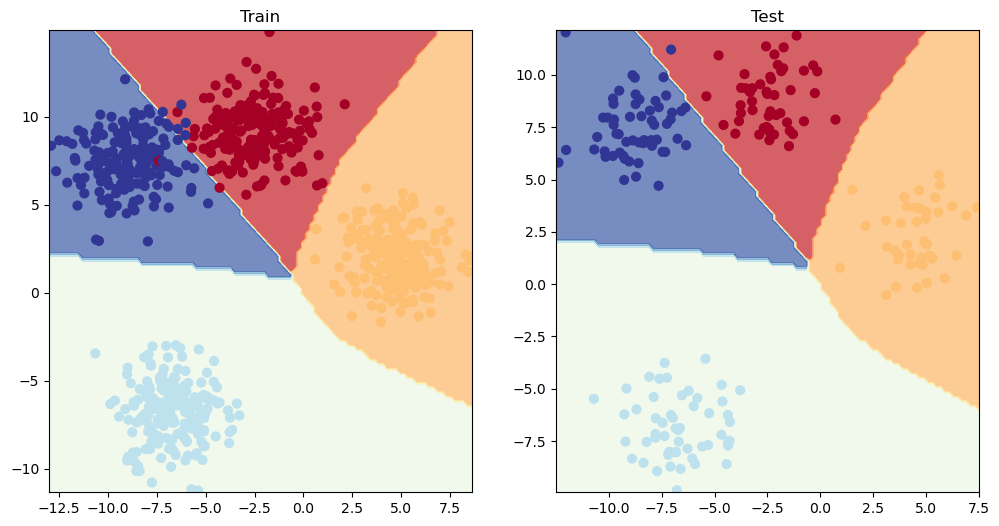

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, Y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, Y_blob_test)

## Few More classification metrics
* Accuracy : **only best for balanced classes**
* Precision
* Recall
* F1-score: **combine precision and recall**
* Confusion matrix
* Classification report

**`documentation--Precision/recall`**: 
* https://towardsdatascience.com/beyond-accuracy-other-classification-metrics-you-should-know-in-machine-learning-ea671be83bb7

**`documentation - pytorch metrics`**: 
* https://torchmetrics.readthedocs.io/en/stable/

In [24]:
from torchmetrics import Accuracy

## create a object of the Accuracy class--> default device: "cpu"
model_accuracy = Accuracy().to(device)

## calculate accuracy
print(f"Model accuracy: {model_accuracy(y_preds,Y_blob_test).item():.3f}%")

Model accuracy: 0.995%
